In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import albumentations as A

LOADING AND PREPROCESSING OF DATASET

In [12]:

# Directories where the images and masks are stored
image_dir = r'D:/Downloads/flood/Image/'  
mask_dir = r'D:/Downloads/flood/Mask/'   

# Configuration settings
image_size = (256, 256)  
batch_size = 16          
num_classes = 1          #flood or no-flood only

# Augmentation with albumentations
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),       
    A.Rotate(limit=90, p=0.5),      
])

def load_image_and_mask(image_path, mask_path, target_size, augment=False):

    # Load and resize the image and mask
    image = load_img(image_path, target_size=target_size)
    mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")
    
    # Convert to arrays and normalize pixel values to [0, 1]
    image_array = img_to_array(image) / 255.0
    mask_array = img_to_array(mask) / 255.0

    if augment:
        augmented = augmentation_pipeline(image=image_array, mask=mask_array)
        image_array = augmented['image']
        mask_array = augmented['mask']
    
    return image_array, mask_array

def load_data(image_dir, mask_dir, image_size, augment=False):
    """Main function to load and preprocess images and masks from directories."""
    image_files = sorted(os.listdir(image_dir))  # List and sort image files
    mask_files = sorted(os.listdir(mask_dir))    # List and sort mask files
    
    images, masks = [], []  # Empty lists to store images and masks
    
    # Iterate over the sorted files and load corresponding images and masks
    for image_file, mask_file in zip(image_files, mask_files):

        # Construction of the full paths
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)
        
        # Load image and mask with augmentation
        image, mask = load_image_and_mask(image_path, mask_path, image_size, augment)
        images.append(image)
        masks.append(mask)
    
    # Convert lists of images and masks to numpy arrays
    return np.array(images), np.array(masks)

# Load the data from the specified directories with augmentation
images, masks = load_data(image_dir, mask_dir, image_size, augment=True)


C:\Users\kobem\AppData\Roaming\Python\Python38\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [13]:
#Train test split
Xtrain, Xval, ytrain, yval = train_test_split(images, masks, test_size=0.2, random_state=42)

In [14]:
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Using segmentation_models's pre-built Unet with EfficientNet encoder with ImageNet encoder weights
model = sm.Unet('efficientnetb2', 
                input_shape=(256, 256, 3), 
                classes=1,  
                activation='sigmoid',  
                encoder_weights='imagenet') 

# Compile the model with Binary Focal Loss + Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=2e-4),  # Custom learning rate for Adam
    loss=tf.keras.losses.BinaryFocalCrossentropy(),  # Focal loss for imbalanced classes
    metrics=[sm.metrics.iou_score]  # Include IOU score for evaluation
)

# #Binary Focal Loss + RMSProp optimizer
# model.compile(
#     optimizer=keras.optimizers.RMSprop(learning_rate=2e-4),
#     loss = keras.losses.BinaryFocalCrossentropy(),
#     metrics = [sm.metrics.iou_score],
# )

# #Binary Focal Loss + Nadam
# model.compile(
#     optimizer=keras.optimizers.Nadam(learning_rate=2e-4),
#     loss = keras.losses.BinaryFocalCrossentropy(),
#     metrics = [sm.metrics.iou_score],
# )

In [15]:
# Train for 10 epochs before starting early stopping (for no-augmentation)
history_1 = model.fit(
    Xtrain, ytrain,  
    validation_data=(Xval, yval), 
    batch_size=16, 
    epochs=10
)

early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=5,                
    restore_best_weights=True,  
    verbose=1
)

history_2 = model.fit(
    Xtrain, ytrain,  
    validation_data=(Xval, yval), 
    batch_size=16, 
    epochs=40,
    callbacks=[early_stopping]
)

Epoch 1/10
15/15 [==============================] - 26s 678ms/step - loss: 0.1466 - iou_score: 0.3776 - val_loss: 0.2014 - val_iou_score: 0.2539
Epoch 2/10
15/15 [==============================] - 7s 436ms/step - loss: 0.0932 - iou_score: 0.4513 - val_loss: 0.1189 - val_iou_score: 0.3587
Epoch 3/10
15/15 [==============================] - 6s 432ms/step - loss: 0.0749 - iou_score: 0.4859 - val_loss: 0.1103 - val_iou_score: 0.3610
Epoch 4/10
15/15 [==============================] - 6s 434ms/step - loss: 0.0667 - iou_score: 0.5081 - val_loss: 0.1081 - val_iou_score: 0.3776
Epoch 5/10
15/15 [==============================] - 6s 434ms/step - loss: 0.0587 - iou_score: 0.5298 - val_loss: 0.1358 - val_iou_score: 0.3937
Epoch 6/10
15/15 [==============================] - 7s 441ms/step - loss: 0.0542 - iou_score: 0.5443 - val_loss: 0.1417 - val_iou_score: 0.4057
Epoch 7/10
15/15 [==============================] - 7s 453ms/step - loss: 0.0505 - iou_score: 0.5604 - val_loss: 0.1408 - val_iou_score

C:\Users\kobem\AppData\Local\Temp\ipykernel_25340\312370010.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


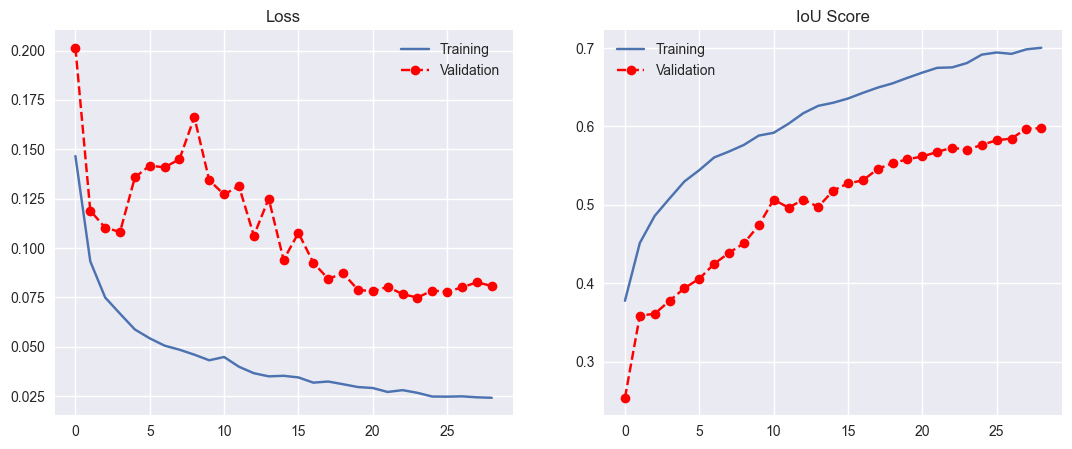

In [16]:
# Merging histories
history_combined = history_1.history.copy()  

# Append both histories
for key in history_2.history:
    history_combined[key] += history_2.history[key]

# Plotting training and validation loss & IoU score
plt.style.use('seaborn')

plt.figure(figsize=(13, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history_combined['loss'], label='Training')
plt.plot(history_combined['val_loss'], '--r', marker='o', label='Validation')
plt.legend()

# Plot IoU Score
plt.subplot(1, 2, 2)
plt.title('IoU Score')
plt.plot(history_combined['iou_score'], label='Training')
plt.plot(history_combined['val_iou_score'], '--r', marker='o', label='Validation')
plt.legend()

plt.show()

In [17]:
color = np.array([161, 205, 255])/255.0

def modify_mask(mask):
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=0.5, 1)
    return t_mask

def make_pred_good(pred):
    pred = pred[0][:, :, :]
    pred = modify_mask(pred[:, :, 0])
    pred = np.repeat(pred, 3, 2)
    return pred

def placeMaskOnImg(img, mask):
    np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
    return img

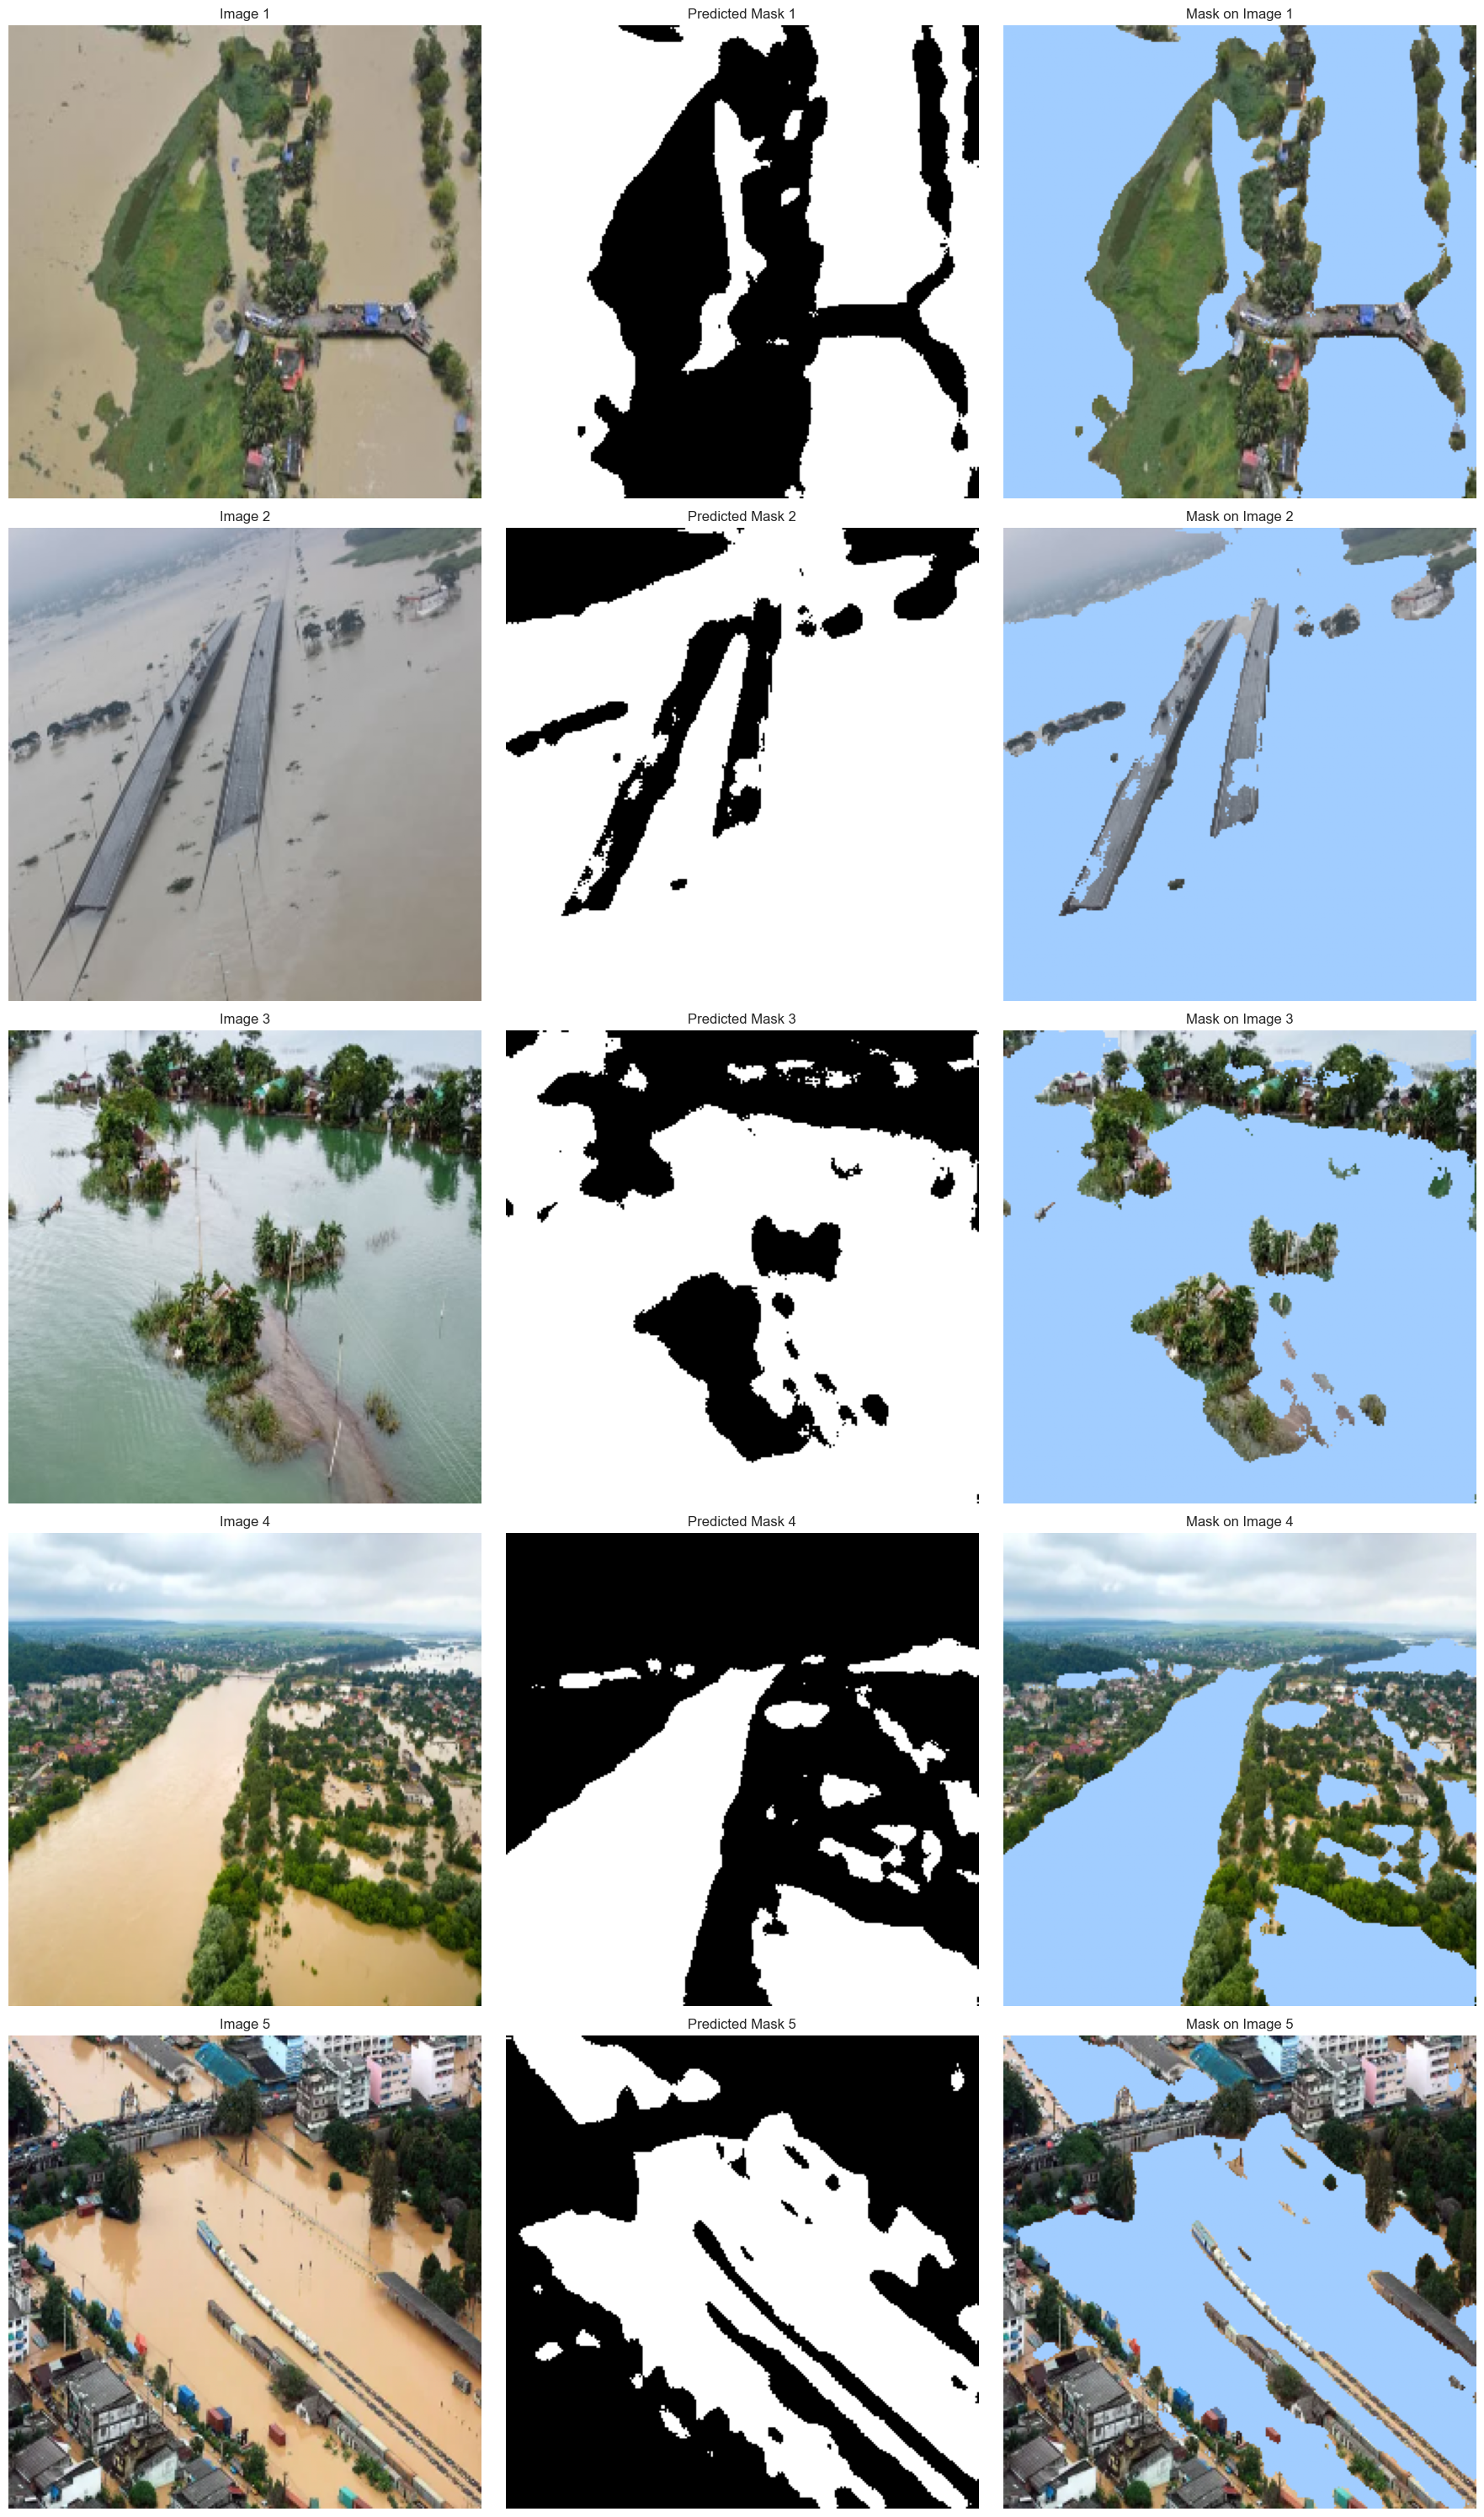

In [18]:
import cv2 as op

color = np.array([161, 205, 255])/255.0

import requests
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#Images uploaded online
urls = [
	'https://scontent-atl3-2.xx.fbcdn.net/v/t1.15752-9/470053072_561704049994434_6518895557233046479_n.jpg?_nc_cat=111&ccb=1-7&_nc_sid=0024fc&_nc_eui2=AeE-rTKXrhXmvnLI9ss6PX5Y-F43_DJJA6H4Xjf8MkkDofs9UlSRs19HrnbfBkIXUvjzDG28d-ApK8gSboNTqPRC&_nc_ohc=-mflZYTm5UAQ7kNvgEtoqhu&_nc_ad=z-m&_nc_cid=0&_nc_zt=23&_nc_ht=scontent-atl3-2.xx&oh=03_Q7cD1gFKYG1SiXm6k8cHEcfaLJox6QxjXzai5UZH0Ctz1tAIPw&oe=678AEAA6',
	'https://scontent-atl3-2.xx.fbcdn.net/v/t1.15752-9/462587215_443671195468553_6948116186625443956_n.jpg?stp=dst-jpg_s552x414_tt6&_nc_cat=104&ccb=1-7&_nc_sid=0024fc&_nc_eui2=AeFRCkeUYwyvduF7xXTNZvMvIxCKcTbKu5AjEIpxNsq7kHAfIfq9Olhc3lETrHCnM4iIJVOXzYQmI3FNaZYjMGZt&_nc_ohc=abC3F4TMBu4Q7kNvgFvdvsj&_nc_ad=z-m&_nc_cid=0&_nc_zt=23&_nc_ht=scontent-atl3-2.xx&oh=03_Q7cD1gFFXodhLN1DwWDtbv7V3vKsDn3Up3sSSMsgbibu6nAjlA&oe=678AF47B',
    'https://scontent-atl3-2.xx.fbcdn.net/v/t1.15752-9/462584384_431720003346594_5876018928549736317_n.jpg?stp=dst-jpg_s552x414_tt6&_nc_cat=101&ccb=1-7&_nc_sid=0024fc&_nc_eui2=AeHzqowObDFX_GI3DkSS7BzPnBQn8ReO6qCcFCfxF47qoKgev3DgaRPoTYww9cfUi-TCQAgzOZCH7GBfKppS_5Qn&_nc_ohc=ThmUtk21j3sQ7kNvgE5xU7i&_nc_ad=z-m&_nc_cid=0&_nc_zt=23&_nc_ht=scontent-atl3-2.xx&oh=03_Q7cD1gGeXaFg9qZy3DPpbMJKsbBs8Hcr_9HiQi35-x66tDFZXA&oe=678B138D',
    'https://scontent-atl3-1.xx.fbcdn.net/v/t1.15752-9/462574802_1161003955587672_7613748072186944668_n.webp?stp=dst-webp_s552x414&_nc_cat=107&ccb=1-7&_nc_sid=0024fc&_nc_eui2=AeHDEzHWVh7h_IxY58a_ZKROYZlhb19LVUthmWFvX0tVS8ntZQTTfH06Q2ojqgJ3iIzI1VTWC1spDQPR_XPyI-Zi&_nc_ohc=XKlLJQROwH8Q7kNvgF0s-aj&_nc_ad=z-m&_nc_cid=0&_nc_zt=23&_nc_ht=scontent-atl3-1.xx&oh=03_Q7cD1gGOfPArERa04t9OvJ0CvwHKybAbbZaW9FRz4VrbhatWMA&oe=678AE3DA',
	'https://scontent-atl3-3.xx.fbcdn.net/v/t1.15752-9/462587343_3953342368230958_696971205533333322_n.webp?stp=dst-webp_s600x600&_nc_cat=109&ccb=1-7&_nc_sid=0024fc&_nc_eui2=AeFH8Ao31snVAuewXXBGAXipyrwd9lWzNpfKvB32VbM2l4IJVFW7vbYquQlMlTU6C0JQR7lu-IpfsF212VxNMvI6&_nc_ohc=AtZIVECiMOIQ7kNvgGWq_2_&_nc_ad=z-m&_nc_cid=0&_nc_zt=23&_nc_ht=scontent-atl3-3.xx&oh=03_Q7cD1gGnwXTTShj_X7iC-0i5iwOz8Mm6UiPvdaRkoCLM5JgGVg&oe=678B02AC'
]
# Loop over the 5 images
plt.figure(figsize=(18, 30))  # Adjusts the sizes

for i, url in enumerate(urls, 1):
    #Gets images from the url
    response = requests.get(url)
    bytes_im = io.BytesIO(response.content)
    img = np.array(Image.open(bytes_im))[:, :, :3]  # Convert image to RGB
    
    # Normalizing and Resizing image for the model
    img = img / 255.0
    img = op.resize(img, (256, 256))  # Resize to 256x256
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    
    # Get the predicted mask from the model's output
    pred = make_pred_good(model(img))  

    # Plot each image in a subplot
    plt.subplot(5, 3, 3 * i - 2)
    plt.title(f"Image {i}")
    plt.imshow(img[0])
    plt.axis('off')

    plt.subplot(5, 3, 3 * i - 1)
    plt.title(f"Predicted Mask {i}")
    plt.imshow(pred)
    plt.axis('off')

    plt.subplot(5, 3, 3 * i)
    plt.title(f"Mask on Image {i}")
    plt.imshow(placeMaskOnImg(img[0], pred)) 
    plt.axis('off')

plt.tight_layout()
plt.show()


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

threshold = 0.5

# Functoin that calculates: Precision, Recall, and F1 Score
def evaluate_metrics(y_true, y_pred):
    # Flatten to 1D Arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    y_pred_binary = (y_pred_flat >= threshold).astype(int)

    if not (set(np.unique(y_true_flat)) <= {0, 1} and set(np.unique(y_pred_binary)) <= {0, 1}):
        raise ValueError("Both y_true and y_pred must be binary (0 or 1).")

    # Calculating metrics
    precision = precision_score(y_true_flat, y_pred_binary, zero_division=0)
    recall = recall_score(y_true_flat, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_binary, zero_division=0)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return precision, recall, f1

# Ensuring numpy arrays
y_pred = np.squeeze(y_pred)  
y_val_squeezed = np.squeeze(yval)  

# Flatten both arrays then converting to binary
y_pred_binary = (y_pred >= threshold).astype(int)
y_val_binary = (y_val_squeezed >= threshold).astype(int)

# Ensure both arrays are binary
evaluate_metrics(y_val_binary, y_pred_binary)

Precision: 0.8652
Recall: 0.8884
F1 Score: 0.8767


(0.865243684754191, 0.8883749849442204, 0.8766567768678935)